In [19]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Install required packages
%pip install -q transformers==4.41.0 seqeval scikit-learn torch torchcrf pytorch-crf

In [21]:
!ls -R "/content/drive" | grep train_vped_beta2

train_vped_beta2
/content/drive/MyDrive/dataset/slim/train_vped_beta2:


In [22]:
DATA_DIR = "/content/drive/MyDrive/dataset/vped/train"
TEST_DIR = "/content/drive/MyDrive/dataset/vped/test"
DEV_DIR = "/content/drive/MyDrive/dataset/vped/dev"

In [23]:
import os
BASE_DIR = "/content/drive/MyDrive/dataset/vped"

for p in (BASE_DIR, DATA_DIR, DEV_DIR,):
    print("\nListing:", p)
    for f in os.listdir(p):
        print(" -", repr(f))


Listing: /content/drive/MyDrive/dataset/vped
 - 'README.md'
 - 'train-dev-statistics.txt'
 - 'slot_label.txt'
 - 'intent_label.txt'
 - 'test'
 - 'dev'
 - 'train'

Listing: /content/drive/MyDrive/dataset/vped/train
 - 'seq_in.txt'
 - 'seq_out.txt'
 - 'seq_intent_out.txt'
 - 'label.txt'

Listing: /content/drive/MyDrive/dataset/vped/dev
 - 'seq_in.txt'
 - 'label.txt'
 - 'seq_intent_out.txt'
 - 'seq_out.txt'


In [24]:
# ======================
# 1) IMPORTS & CONSTANTS
# ======================

import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from pathlib import Path
from typing import List, Dict, Tuple
from sklearn.metrics import precision_recall_fscore_support, f1_score
from seqeval.metrics import f1_score as seq_f1
from collections import Counter
import matplotlib.pyplot as plt
from torchcrf import CRF
from seqeval.metrics.sequence_labeling import get_entities

# Model and training configuration
MODEL_NAME = "vinai/phobert-base-v2"
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 50
LR = 5e-5
WEIGHT_DECAY = 0.01
SEED = 36
IGNORE_INDEX = -100
NUM_MASK = 4  # Maximum number of slot entities per utterance

W_SLOT = 2.0 # cũ 2.0
W_TOKINTENT = 2.0
W_UTTINTENT = 1.0
W_TAGINTENT = 1.0

# Inference threshold
UTT_THRESHOLD = 0.5

In [25]:
# ================================
# 2) LOAD LABEL SCHEMA FROM FILES
# ================================

def load_labels_from_file(file_path: str) -> List[str]:
    """
    Load labels from text file (one label per line)
    """
    labels = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith("#"):  # Skip empty lines and comments
                labels.append(line)
    return labels

# Config file paths
INTENT_LABEL_FILE = "/content/drive/MyDrive/dataset/vped/intent_label.txt"
SLOT_LABEL_FILE = "/content/drive/MyDrive/dataset/vped/slot_label.txt"

# Load labels from files
print("Loading label schema from config files...")
try:
    INTENT_LABELS = load_labels_from_file(INTENT_LABEL_FILE)
    SLOT_LABELS = load_labels_from_file(SLOT_LABEL_FILE)

    print(f"Loaded {len(INTENT_LABELS)} intent labels from {INTENT_LABEL_FILE}")
    print(f"Loaded {len(SLOT_LABELS)} slot labels from {SLOT_LABEL_FILE}")

except FileNotFoundError as e:
    print(f"Error: Config file not found - {e}")
    raise

# Generate token-intent labels (O + intents)
TOKEN_INTENT_LABELS = ["O"] + INTENT_LABELS

# Add PAD for tag-intent
INTENT_LABELS_WITH_PAD = ["PAD"] + INTENT_LABELS

# Create mappings
INTENT2ID = {intent: i for i, intent in enumerate(INTENT_LABELS)}
ID2INTENT = {i: intent for intent, i in INTENT2ID.items()}

SLOT2ID = {slot: i for i, slot in enumerate(SLOT_LABELS)}
ID2SLOT = {i: slot for slot, i in SLOT2ID.items()}

TOKINT2ID = {tokint: i for i, tokint in enumerate(TOKEN_INTENT_LABELS)}
ID2TOKINT = {i: tokint for tokint, i in TOKINT2ID.items()}

TAGINT2ID = {intent: i for i, intent in enumerate(INTENT_LABELS_WITH_PAD)}
ID2TAGINT = {i: intent for intent, i in TAGINT2ID.items()}

print(f"\n📋 Label Schema Summary:")
print(f"  - Intent labels ({len(INTENT_LABELS)}): {INTENT_LABELS}")
print(f"  - Slot labels ({len(SLOT_LABELS)}): first 10 = {SLOT_LABELS[:10]}")
print(f"  - Token-intent labels ({len(TOKEN_INTENT_LABELS)}): {TOKEN_INTENT_LABELS}")
print(f"  - Tag-intent labels ({len(INTENT_LABELS_WITH_PAD)}): {INTENT_LABELS_WITH_PAD}")

# Set random seed
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {DEVICE}")


Loading label schema from config files...
Loaded 5 intent labels from /content/drive/MyDrive/dataset/vped/intent_label.txt
Loaded 17 slot labels from /content/drive/MyDrive/dataset/vped/slot_label.txt

📋 Label Schema Summary:
  - Intent labels (5): ['add_expense', 'update_expense', 'delete_expense', 'search_expense', 'stat_expense']
  - Slot labels (17): first 10 = ['O', 'B-target_date', 'I-target_date', 'B-target_price', 'I-target_price', 'B-target_description', 'I-target_description', 'B-target_location', 'I-target_location', 'B-condition_date']
  - Token-intent labels (6): ['O', 'add_expense', 'update_expense', 'delete_expense', 'search_expense', 'stat_expense']
  - Tag-intent labels (6): ['PAD', 'add_expense', 'update_expense', 'delete_expense', 'search_expense', 'stat_expense']
Using device: cuda


In [26]:
# =================
# 3) MODULE CLASSES
# =================

class MultiIntentClassifier(nn.Module):
    def __init__(self, input_dim, num_intent_labels, dropout_rate=0.):
        super(MultiIntentClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, num_intent_labels)
        self.sigmoid = nn.Sigmoid()
        self.reset_params()

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear(x)
        return self.sigmoid(x)

    def reset_params(self):
        nn.init.uniform_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

class SlotClassifier(nn.Module):
    def __init__(self, input_dim, num_slot_labels, dropout_rate=0.2):
        super(SlotClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, num_slot_labels)

    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)

class IntentTokenClassifier(nn.Module):
    def __init__(self, input_dim, num_intent_labels, dropout_rate=0.):
        super(IntentTokenClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, num_intent_labels)

    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)

class TagIntentClassifier(nn.Module):
    def __init__(self, input_dim, num_intent_labels, dropout_rate=0.):
        super(TagIntentClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, num_intent_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.dropout(x)
        return self.softmax(self.linear(x))


class BiaffineTagIntentClassifier(nn.Module):
    """
    Biaffine Tag-Intent Classifier
    score = h_cls^T U r + W [h_cls; r] + b
    """
    def __init__(self, input_dim, num_intent_labels, dropout_rate=0.):
        super(BiaffineTagIntentClassifier, self).__init__()
        self.input_dim = input_dim
        self.num_intent_labels = num_intent_labels

        self.dropout = nn.Dropout(dropout_rate)

        # Bilinear term: U (input_dim x input_dim x num_intent_labels)
        self.U = nn.Parameter(torch.Tensor(num_intent_labels, input_dim, input_dim))

        # Linear term: W (2*input_dim x num_intent_labels)
        self.W = nn.Linear(2 * input_dim, num_intent_labels)

        # Softmax
        self.softmax = nn.Softmax(dim=1)

        self.reset_params()

    def forward(self, h_cls, r):
        """
        Args:
            h_cls: [batch*num_mask, hidden_dim] - CLS representations
            r: [batch*num_mask, hidden_dim] - tag intent vectors

        Returns:
            [batch*num_mask, num_intent_labels] - probabilities
        """
        h_cls = self.dropout(h_cls)
        r = self.dropout(r)

        # Bilinear term: h_cls^T U r
        # h_cls: [B, H], U: [C, H, H], r: [B, H]
        # Result: [B, C]
        bilinear_scores = torch.einsum('bh,chd,bd->bc', h_cls, self.U, r)

        # Linear term: W [h_cls; r]
        concat = torch.cat([h_cls, r], dim=1)  # [B, 2H]
        linear_scores = self.W(concat)  # [B, C]

        # Total score
        scores = bilinear_scores + linear_scores

        return self.softmax(scores)

    def reset_params(self):
        nn.init.xavier_uniform_(self.U)
        nn.init.xavier_uniform_(self.W.weight)
        nn.init.zeros_(self.W.bias)

In [27]:
# ================================
# 4) MAIN MODEL (EXACT PAPER ARCHITECTURE)
# ================================

class VSLIM(nn.Module):
    """
    Features:
    - Multi-intent classification with sigmoid
    - Slot filling with optional CRF
    - Intent token classification
    - Tag-intent classification with B/BI masks
    - Intent attention for tag-intent
    """

    def __init__(self,
             model_name,
             num_slots,
             num_intents,
             num_token_intents,
             num_tag_intents,
             dropout=0.1,
             use_crf=False,
             num_mask=4,
             cls_token_cat=True,
             intent_attn=True,
             use_biaffine_tag_intent=True):
      super().__init__()

      # PhoBERT encoder
      self.encoder = AutoModel.from_pretrained(model_name)
      hidden_size = self.encoder.config.hidden_size

      # Classification heads
      self.multi_intent_classifier = MultiIntentClassifier(hidden_size, num_intents, dropout)
      self.slot_classifier = SlotClassifier(hidden_size, num_slots, dropout)
      self.intent_token_classifier = IntentTokenClassifier(hidden_size, num_token_intents, dropout)

      # Tag-intent classifier: Biaffine or Linear
      self.use_biaffine_tag_intent = use_biaffine_tag_intent

      if use_biaffine_tag_intent:
          # Biaffine classifier: both h_cls và r have dim = hidden_size
          self.biaffine_tag_intent_classifier = BiaffineTagIntentClassifier(
              hidden_size, num_tag_intents, dropout
          )
      else:
          # Linear classifier (concat [CLS; r])
          tag_input_dim = 2 * hidden_size if cls_token_cat else hidden_size
          self.tag_intent_classifier = TagIntentClassifier(tag_input_dim, num_tag_intents, dropout)

      if use_crf:
          self.crf = CRF(num_tags=num_slots, batch_first=True)

      self.use_crf = use_crf
      self.num_mask = num_mask
      self.cls_token_cat = cls_token_cat
      self.intent_attn = intent_attn
      self.num_intents = num_intents

    def forward(self, input_ids, attention_mask, token_type_ids=None,
                intent_label_ids=None, slot_labels_ids=None,
                intent_token_ids=None, B_tag_mask=None, BI_tag_mask=None,
                tag_intent_label=None):
        # Encode with PhoBERT
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [batch, seq_len, hidden]
        pooled_output = outputs.pooler_output        # [batch, hidden]

        total_loss = 0

        # ==================================== 1. Multi-Intent Classification ========================================
        intent_logits = self.multi_intent_classifier(pooled_output)  # [batch, num_intents]

        if intent_label_ids is not None:
            intent_loss_fct = nn.BCELoss()
            intent_loss = intent_loss_fct(intent_logits + 1e-10, intent_label_ids)
            total_loss += W_UTTINTENT * intent_loss

        # ==================================== 2. Slot Classification ========================================
        slot_logits = self.slot_classifier(sequence_output)  # [batch, seq_len, num_slots]

        if slot_labels_ids is not None:
            if self.use_crf:
                slot_loss = self.crf(slot_logits, slot_labels_ids, mask=attention_mask.byte(), reduction='mean')
                slot_loss = -1 * slot_loss  # negative log-likelihood
            else:
                slot_loss_fct = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = slot_logits.view(-1, slot_logits.size(-1))[active_loss]
                    active_labels = slot_labels_ids.view(-1)[active_loss]
                    slot_loss = slot_loss_fct(active_logits, active_labels)
                else:
                    slot_loss = slot_loss_fct(slot_logits.view(-1, slot_logits.size(-1)), slot_labels_ids.view(-1))

            total_loss += W_SLOT * slot_loss

        # ==================================== 3. Intent Token Classification ========================================
        intent_token_logits = self.intent_token_classifier(sequence_output)

        intent_token_loss = 0.0
        if intent_token_ids is not None:
            if self.use_crf:
                intent_token_loss = self.crf(intent_token_logits, intent_token_ids, mask=attention_mask.byte(), reduction='mean')
                intent_token_loss = -1 * intent_token_loss
            else:
                intent_token_loss_fct = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
                if attention_mask is not None:
                    active_intent_loss = attention_mask.view(-1) == 1
                    active_intent_logits = intent_token_logits.view(-1, intent_token_logits.size(-1))[active_intent_loss]
                    active_intent_tokens = intent_token_ids.view(-1)[active_intent_loss]
                    intent_token_loss = intent_token_loss_fct(active_intent_logits, active_intent_tokens)
                else:
                    intent_token_loss = intent_token_loss_fct(intent_token_logits.view(-1, intent_token_logits.size(-1)), intent_token_ids.view(-1))

            total_loss += W_TOKINTENT * intent_token_loss

        # ==================================== 4. Tag-Intent Classification ========================================
        tag_intent_loss = 0.0
        tag_intent_logits = None

        if B_tag_mask is not None and BI_tag_mask is not None and tag_intent_label is not None:
            if BI_tag_mask.type() != torch.cuda.FloatTensor:
                BI_tag_mask = BI_tag_mask.type(torch.cuda.FloatTensor)
            if B_tag_mask.type() != torch.cuda.FloatTensor:
                B_tag_mask = B_tag_mask.type(torch.cuda.FloatTensor)

            # Use BI_tag_mask for weighted pooling
            tag_intent_vec = torch.einsum('bml,bld->bmd', BI_tag_mask, sequence_output)  # [batch, num_mask, hidden]

            # BIAFFINE TAG-INTENT CLASSIFICATION
            if self.use_biaffine_tag_intent:
                # h_cls: pooled_output [batch, hidden]
                h_cls = pooled_output.unsqueeze(1)  # [batch, 1, hidden]
                h_cls = h_cls.repeat(1, self.num_mask, 1)  # [batch, num_mask, hidden]

                # r: tag_intent_vec [batch, num_mask, hidden]
                batch_size = h_cls.size(0)
                h_cls_flat = h_cls.view(batch_size * self.num_mask, -1)  # [batch*num_mask, hidden]
                r_flat = tag_intent_vec.view(batch_size * self.num_mask, -1)  # [batch*num_mask, hidden]

                # Biaffine classification
                tag_intent_logits = self.biaffine_tag_intent_classifier(h_cls_flat, r_flat)  # [batch*num_mask, num_tag_intents]

            else:
                if self.cls_token_cat:
                    cls_token = pooled_output.unsqueeze(1)  # [batch, 1, hidden]
                    cls_token = cls_token.repeat(1, self.num_mask, 1)  # [batch, num_mask, hidden]
                    tag_intent_vec = torch.cat((cls_token, tag_intent_vec), dim=2)  # [batch, num_mask, 2*hidden]

                tag_intent_vec = tag_intent_vec.view(tag_intent_vec.size(0) * tag_intent_vec.size(1), -1)
                tag_intent_logits = self.tag_intent_classifier(tag_intent_vec)  # [batch*num_mask, num_tag_intents]

            if self.intent_attn:
                intent_probs = intent_logits.unsqueeze(1)  # [batch, 1, num_intents]
                intent_probs = intent_probs.repeat(1, self.num_mask, 1)  # [batch, num_mask, num_intents]
                intent_probs = intent_probs.view(intent_probs.size(0) * intent_probs.size(1), -1)  # [batch*num_mask, num_intents]

                # Add PAD dimension to intent_probs
                pad_probs = torch.zeros(intent_probs.size(0), 1, device=intent_probs.device)  # [batch*num_mask, 1] for PAD
                intent_probs_expanded = torch.cat([pad_probs, intent_probs], dim=1)  # [batch*num_mask, 6]

                # Apply attention weighting
                tag_intent_logits = tag_intent_logits * intent_probs_expanded
                tag_intent_logits = tag_intent_logits.div(tag_intent_logits.sum(dim=1, keepdim=True) + 1e-10)

            nll_fct = nn.NLLLoss(ignore_index=IGNORE_INDEX)
            tag_intent_loss = nll_fct(torch.log(tag_intent_logits + 1e-10), tag_intent_label.view(-1))
            total_loss += W_TAGINTENT * tag_intent_loss

        return {
            "total_loss": total_loss,
            "intent_loss": intent_loss if intent_label_ids is not None else 0,
            "slot_loss": slot_loss if slot_labels_ids is not None else 0,
            "intent_token_loss": intent_token_loss,
            "tag_intent_loss": tag_intent_loss,
            "intent_logits": intent_logits,
            "slot_logits": slot_logits,
            "intent_token_logits": intent_token_logits, # if intent_token_ids is not None else None,
            "tag_intent_logits": tag_intent_logits if B_tag_mask is not None else None
        }


In [ ]:
# ===============
# 5) DATA LOADING
# ===============

def read_lines(file_path: Path) -> List[str]:
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.rstrip("\n") for line in f]

def resolve_file(base_dir: Path, name: str) -> Path:
    candidates = [base_dir / name, base_dir / f"{name}.txt"]
    for path in candidates:
        if path.exists():
            return path
    raise FileNotFoundError(f"Cannot find {name}(.txt) in {base_dir}")

def load_data_with_masks(data_dir: str, is_test: bool = False) -> Tuple:
    """
    Load data with B/BI masks for tag-intent
    """
    base = Path(data_dir)

    # Load files seq, label, seq_intent
    seq_in_path = resolve_file(base, "seq_in")
    label_path = resolve_file(base, "label")
    seq_out_path = resolve_file(base, "seq_out")
    seq_intent_path = resolve_file(base, "seq_intent_out")

    seq_in_lines = read_lines(seq_in_path)
    label_lines = read_lines(label_path)
    seq_out_lines = read_lines(seq_out_path)
    seq_intent_lines = read_lines(seq_intent_path)

    n = len(seq_in_lines)
    assert len(label_lines) == n
    assert len(seq_out_lines) == n
    assert len(seq_intent_lines) == n

    sentences = []
    slot_tags = []
    token_intent_tags = []
    utterance_intents = []
    B_tag_masks = []
    BI_tag_masks = []
    tag_intent_labels = []

    for i in range(n):
        tokens = seq_in_lines[i].strip().split()
        sentences.append(tokens)

        label_line = label_lines[i].strip()
        if label_line == "":
            utterance_intents.append(["none"])
        else:
            utterance_intents.append(label_line.split("#"))

        slot_line = seq_out_lines[i].strip()
        if slot_line == "":
            slot_tags.append(["O"] * len(tokens))
        else:
            raw_slots = slot_line.split()
            if len(raw_slots) < len(tokens):
                raw_slots = raw_slots + ["O"] * (len(tokens) - len(raw_slots))
            elif len(raw_slots) > len(tokens):
                raw_slots = raw_slots[:len(tokens)]
            slot_tags.append(raw_slots)

        tokint_line = seq_intent_lines[i].strip()
        if tokint_line == "":
            token_intent_tags.append(["O"] * len(tokens))
        else:
            raw_tokints = tokint_line.split()
            if len(raw_tokints) < len(tokens):
                raw_tokints = raw_tokints + ["O"] * (len(tokens) - len(raw_tokints))
            elif len(raw_tokints) > len(tokens):
                raw_tokints = raw_tokints[:len(tokens)]
            token_intent_tags.append(raw_tokints)

        # Generate B/BI masks and tag-intent labels
        entities = get_entities(slot_line.split())
        if len(entities) > NUM_MASK:
            entities = entities[:NUM_MASK]

        B_tag_mask = [[0 for _ in range(len(tokens))] for _ in range(NUM_MASK)]
        BI_tag_mask = [[0 for _ in range(len(tokens))] for _ in range(NUM_MASK)]
        tag_intent_label = [TAGINT2ID["PAD"] for _ in range(NUM_MASK)]

        try:
            for idx, (tag, start, end) in enumerate(entities):
                B_tag_mask[idx][start] = 1
                # Weighted BI mask
                weight = 1.0 / (end - start + 1)
                BI_tag_mask[idx][start:end+1] = [weight] * (end - start + 1)
                # Tag intent label from token intent at start position
                if start < len(token_intent_tags[-1]):
                    tokint_tag = token_intent_tags[-1][start]
                    if tokint_tag in TOKINT2ID and tokint_tag != "O":
                        tag_intent_label[idx] = TAGINT2ID[tokint_tag]
        except:
            pass  # Keep default PAD labels

        B_tag_masks.append(B_tag_mask)
        BI_tag_masks.append(BI_tag_mask)
        tag_intent_labels.append(tag_intent_label)

    print(f"Loaded {n} examples from {data_dir}")
    print(f"Sample: tokens={sentences[0][:5]}, intents={utterance_intents[0]}, slots={slot_tags[0][:5]}")

    return (sentences, slot_tags, token_intent_tags, utterance_intents,
            B_tag_masks, BI_tag_masks, tag_intent_labels)

train_data = load_data_with_masks(DATA_DIR)
train_sentences, train_slot_tags, train_token_intent_tags, train_utterance_intents, \
train_B_masks, train_BI_masks, train_tag_intent_labels = train_data

dev_data = load_data_with_masks(DEV_DIR)
dev_sentences, dev_slot_tags, dev_token_intent_tags, dev_utterance_intents, \
dev_B_masks, dev_BI_masks, dev_tag_intent_labels = dev_data

Loaded 1014 examples from /content/drive/MyDrive/dataset/vped/train
Sample: tokens=['Còn', 'cái', 'viettel', 'đầu', 'năm'], intents=['add_expense', 'delete_expense'], slots=['O', 'O', 'B-condition_description', 'B-condition_date', 'I-condition_date']
Loaded 210 examples from /content/drive/MyDrive/dataset/vped/dev
Sample: tokens=['Hqua', 'mua', 'đèn', 'trên', 'tiktok'], intents=['add_expense'], slots=['B-target_date', 'O', 'B-target_description', 'O', 'O']


In [ ]:
# ================
# 6) DATASET CLASS
# ================

class VSLIMDataset(Dataset):
    def __init__(self, sentences, slot_tags, token_intent_tags, utterance_intents,
                 B_masks, BI_masks, tag_intent_labels, tokenizer, max_len=MAX_LEN):
        self.sentences = sentences
        self.slot_tags = slot_tags
        self.token_intent_tags = token_intent_tags
        self.utterance_intents = utterance_intents
        self.B_masks = B_masks
        self.BI_masks = BI_masks
        self.tag_intent_labels = tag_intent_labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.num_intents = len(INTENT_LABELS)
        self.num_tag_intents = len(INTENT_LABELS_WITH_PAD)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.sentences[idx]
        slot_labels = self.slot_tags[idx]
        tokint_labels = self.token_intent_tags[idx]
        utt_intents = self.utterance_intents[idx]
        B_mask = self.B_masks[idx]
        BI_mask = self.BI_masks[idx]
        tag_intent_label = self.tag_intent_labels[idx]

        is_none_utterance = (len(utt_intents) == 1 and utt_intents[0] == "none")

        # Subword tokenization with alignment
        subword_tokens = []
        subword_slot_labels = []
        subword_tokint_labels = []
        subword_B_masks = []
        subword_BI_masks = []

        for token, slot_tag, tokint_tag, B_pos_mask, BI_pos_mask in zip(
            tokens, slot_labels, tokint_labels, zip(*B_mask), zip(*BI_mask)):

            pieces = self.tokenizer.tokenize(token) or [self.tokenizer.unk_token]
            subword_tokens.extend(pieces)

            # Label assignment (first subword only)
            if is_none_utterance:
                subword_slot_labels.extend([IGNORE_INDEX] * len(pieces))
                subword_tokint_labels.extend([IGNORE_INDEX] * len(pieces))
            else:
                slot_id = SLOT2ID.get(slot_tag, SLOT2ID["O"])
                subword_slot_labels.append(slot_id)
                subword_slot_labels.extend([IGNORE_INDEX] * (len(pieces) - 1))

                if tokint_tag == "O":
                    subword_tokint_labels.extend([IGNORE_INDEX] * len(pieces))
                else:
                    tokint_id = TOKINT2ID.get(tokint_tag, TOKINT2ID["O"])
                    subword_tokint_labels.append(tokint_id)
                    subword_tokint_labels.extend([IGNORE_INDEX] * (len(pieces) - 1))

            # B/BI masks (first subword only)
            subword_B_masks.append(B_pos_mask)
            subword_B_masks.extend([(0,) * NUM_MASK] * (len(pieces) - 1))
            subword_BI_masks.append(BI_pos_mask)
            subword_BI_masks.extend([(0.0,) * NUM_MASK] * (len(pieces) - 1))

        # Convert to input IDs
        input_ids = self.tokenizer.convert_tokens_to_ids(subword_tokens)
        input_ids = self.tokenizer.build_inputs_with_special_tokens(input_ids)

        # Add IGNORE_INDEX for special tokens
        subword_slot_labels = [IGNORE_INDEX] + subword_slot_labels + [IGNORE_INDEX]
        subword_tokint_labels = [IGNORE_INDEX] + subword_tokint_labels + [IGNORE_INDEX]
        subword_B_masks = [(0,) * NUM_MASK] + subword_B_masks + [(0,) * NUM_MASK]
        subword_BI_masks = [(0.0,) * NUM_MASK] + subword_BI_masks + [(0.0,) * NUM_MASK]

        attention_mask = [1] * len(input_ids)
        token_type_ids = [0] * len(input_ids)

        # Truncate if necessary
        if len(input_ids) > self.max_len:
            input_ids = input_ids[:self.max_len]
            attention_mask = attention_mask[:self.max_len]
            token_type_ids = token_type_ids[:self.max_len]
            subword_slot_labels = subword_slot_labels[:self.max_len]
            subword_tokint_labels = subword_tokint_labels[:self.max_len]
            subword_B_masks = subword_B_masks[:self.max_len]
            subword_BI_masks = subword_BI_masks[:self.max_len]

        # Pad to max_len
        pad_len = self.max_len - len(input_ids)
        if pad_len > 0:
            pad_id = self.tokenizer.pad_token_id
            input_ids.extend([pad_id] * pad_len)
            attention_mask.extend([0] * pad_len)
            token_type_ids.extend([0] * pad_len)
            subword_slot_labels.extend([IGNORE_INDEX] * pad_len)
            subword_tokint_labels.extend([IGNORE_INDEX] * pad_len)
            subword_B_masks.extend([(0,) * NUM_MASK] * pad_len)
            subword_BI_masks.extend([(0.0,) * NUM_MASK] * pad_len)

        utt_intent_vector = torch.zeros(self.num_intents, dtype=torch.float)
        for intent in utt_intents:
            if intent in INTENT2ID:
                utt_intent_vector[INTENT2ID[intent]] = 1.0

        # Convert B/BI masks to proper format
        B_mask_tensor = torch.tensor(list(zip(*subword_B_masks)), dtype=torch.long).T  # [seq_len, num_mask] -> [num_mask, seq_len]
        BI_mask_tensor = torch.tensor(list(zip(*subword_BI_masks)), dtype=torch.float).T  # [seq_len, num_mask] -> [num_mask, seq_len]
        tag_intent_tensor = torch.tensor(tag_intent_label, dtype=torch.long)

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "slot_labels": torch.tensor(subword_slot_labels, dtype=torch.long),
            "tokint_labels": torch.tensor(subword_tokint_labels, dtype=torch.long),
            "uttint_labels": utt_intent_vector,
            "B_tag_mask": B_mask_tensor,
            "BI_tag_mask": BI_mask_tensor,
            "tag_intent_label": tag_intent_tensor
        }

def collate_fn(batch):
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "token_type_ids": torch.stack([item["token_type_ids"] for item in batch]),
        "slot_labels": torch.stack([item["slot_labels"] for item in batch]),
        "tokint_labels": torch.stack([item["tokint_labels"] for item in batch]),
        "uttint_labels": torch.stack([item["uttint_labels"] for item in batch]),

        "B_tag_mask": torch.stack([item["B_tag_mask"] for item in batch]).transpose(1, 2),  # [batch, seq_len, num_mask] -> [batch, num_mask, seq_len]
        "BI_tag_mask": torch.stack([item["BI_tag_mask"] for item in batch]).transpose(1, 2),  # [batch, seq_len, num_mask] -> [batch, num_mask, seq_len]
        "tag_intent_label": torch.stack([item["tag_intent_label"] for item in batch])
    }


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)
print(f"Tokenizer: {MODEL_NAME}, Fast: {getattr(tokenizer, 'is_fast', False)}")


train_dataset = VSLIMDataset(
    train_sentences, train_slot_tags, train_token_intent_tags, train_utterance_intents,
    train_B_masks, train_BI_masks, train_tag_intent_labels, tokenizer, MAX_LEN
)

dev_dataset = VSLIMDataset(
    dev_sentences, dev_slot_tags, dev_token_intent_tags, dev_utterance_intents,
    dev_B_masks, dev_BI_masks, dev_tag_intent_labels, tokenizer, MAX_LEN
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(dev_dataset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Test data loading
sample_batch = next(iter(train_loader))
print(f"Sample batch shapes:")
for key, tensor in sample_batch.items():
    print(f"  {key}: {tensor.shape}")

print("VSLIM dataset ready!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizer: vinai/phobert-base-v2, Fast: False
Train samples: 1014
Val samples: 210
Train batches: 32
Val batches: 7
Sample batch shapes:
  input_ids: torch.Size([32, 128])
  attention_mask: torch.Size([32, 128])
  token_type_ids: torch.Size([32, 128])
  slot_labels: torch.Size([32, 128])
  tokint_labels: torch.Size([32, 128])
  uttint_labels: torch.Size([32, 5])
  B_tag_mask: torch.Size([32, 4, 128])
  BI_tag_mask: torch.Size([32, 4, 128])
  tag_intent_label: torch.Size([32, 4])
VSLIM dataset ready!


In [30]:
# ================================
# 7) MODEL INITIALIZATION
# ================================

NUM_SLOTS = len(SLOT_LABELS)
NUM_INTENTS = len(INTENT_LABELS)
NUM_TOKEN_INTENTS = len(TOKEN_INTENT_LABELS)
NUM_TAG_INTENTS = len(INTENT_LABELS_WITH_PAD)

model = VSLIM(
    model_name=MODEL_NAME,
    num_slots=NUM_SLOTS,
    num_intents=NUM_INTENTS,
    num_token_intents=NUM_TOKEN_INTENTS,
    num_tag_intents=NUM_TAG_INTENTS,
    dropout=0.1,
    use_crf=False,
    num_mask=NUM_MASK,
    cls_token_cat=True,
    intent_attn=True,
    use_biaffine_tag_intent=True
)

model.to(DEVICE)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Tag-Intent Classifier: {'Biaffine' if model.use_biaffine_tag_intent else 'Linear'}")

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 138567970 parameters
Tag-Intent Classifier: Biaffine


In [31]:
# Thêm vào trước training loop
print("DEBUGGING MASK SHAPES...")
sample_batch = next(iter(train_loader))
print(f"sequence_output shape: [batch, seq_len, hidden]")
print(f"BI_tag_mask shape: {sample_batch['BI_tag_mask'].shape}")
print(f"B_tag_mask shape: {sample_batch['B_tag_mask'].shape}")
print(f"Expected: BI_tag_mask should be [batch, num_mask, seq_len]")
print("="*60)

DEBUGGING MASK SHAPES...
sequence_output shape: [batch, seq_len, hidden]
BI_tag_mask shape: torch.Size([32, 4, 128])
B_tag_mask shape: torch.Size([32, 4, 128])
Expected: BI_tag_mask should be [batch, num_mask, seq_len]


In [ ]:
# =================
# 8) TRAINING LOOP 
# =================

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': WEIGHT_DECAY
    },
    {
        'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

def train_epoch():
    model.train()
    total_loss = 0
    total_intent_loss = 0
    total_slot_loss = 0
    total_tokint_loss = 0
    total_tagint_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Move to device
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        # Forward pass
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            intent_label_ids=batch["uttint_labels"],
            slot_labels_ids=batch["slot_labels"],
            intent_token_ids=batch["tokint_labels"],
            B_tag_mask=batch["B_tag_mask"],
            BI_tag_mask=batch["BI_tag_mask"],
            tag_intent_label=batch["tag_intent_label"]
        )

        # Backward pass
        outputs["total_loss"].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Accumulate losses
        total_loss += outputs["total_loss"].item()
        total_intent_loss += outputs["intent_loss"]
        total_slot_loss += outputs["slot_loss"]
        total_tokint_loss += outputs["intent_token_loss"]
        total_tagint_loss += outputs["tag_intent_loss"]

    return (
        total_loss / len(train_loader),
        total_intent_loss / len(train_loader),
        total_slot_loss / len(train_loader),
        total_tokint_loss / len(train_loader),
        total_tagint_loss / len(train_loader)
    )

@torch.no_grad()
def validate():
    model.eval()
    total_loss = 0
    total_intent_loss = 0
    total_slot_loss = 0
    total_tokint_loss = 0
    total_tagint_loss = 0

    for batch in val_loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            intent_label_ids=batch["uttint_labels"],
            slot_labels_ids=batch["slot_labels"],
            intent_token_ids=batch["tokint_labels"],
            B_tag_mask=batch["B_tag_mask"],
            BI_tag_mask=batch["BI_tag_mask"],
            tag_intent_label=batch["tag_intent_label"]
        )

        total_loss += outputs["total_loss"].item()
        total_intent_loss += outputs["intent_loss"]
        total_slot_loss += outputs["slot_loss"]
        total_tokint_loss += outputs["intent_token_loss"]
        total_tagint_loss += outputs["tag_intent_loss"]

    return (
        total_loss / len(val_loader),
        total_intent_loss / len(val_loader),
        total_slot_loss / len(val_loader),
        total_tokint_loss / len(val_loader),
        total_tagint_loss / len(val_loader)
    )

# Training loop
best_val_loss = float('inf')
patience_counter = 0
patience = 5
train_losses = []
val_losses = []

print("Starting training...")
print(f"Total epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LR}")
print(f"Loss weights: slot={W_SLOT}, tokint={W_TOKINTENT}, uttint={W_UTTINTENT}, tagint={W_TAGINTENT}")
print("-" * 80)

for epoch in range(EPOCHS):
    # Train
    train_loss, train_intent, train_slot, train_tokint, train_tagint = train_epoch()

    # Validate
    val_loss, val_intent, val_slot, val_tokint, val_tagint = validate()

    # Save losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress
    print(f"Epoch {epoch+1:2d}/{EPOCHS}")
    print(f"  Train: total={train_loss:.4f} (intent={train_intent:.4f}, slot={train_slot:.4f}, tokint={train_tokint:.4f}, tagint={train_tagint:.4f})")
    print(f"  Val:   total={val_loss:.4f} (intent={val_intent:.4f}, slot={val_slot:.4f}, tokint={val_tokint:.4f}, tagint={val_tagint:.4f})")

#     # Early stopping
#     if val_loss < best_val_loss - 1e-4:
#         best_val_loss = val_loss
#         patience_counter = 0
#         torch.save(model.state_dict(), "slim_full_best_model.pt")
#         print("  ✓ New best model saved!")
#     else:
#         patience_counter += 1
#         print(f"  No improvement ({patience_counter}/{patience})")

#     if patience_counter >= patience:
#         print("  Early stopping triggered!")
#         break

#     print()

# # Load best model
# model.load_state_dict(torch.load("slim_full_best_model.pt", map_location=DEVICE))
print("Best model loaded for inference and evaluation.")

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training...
Total epochs: 50
Batch size: 32
Learning rate: 5e-05
Loss weights: slot=2.0, tokint=2.0, uttint=1.0, tagint=1.0
--------------------------------------------------------------------------------
Epoch  1/50
  Train: total=14.7967 (intent=0.9514, slot=2.7085, tokint=1.7886, tagint=4.8512)
  Val:   total=16.0348 (intent=0.5399, slot=2.5449, tokint=1.7386, tagint=6.9278)
Epoch  2/50
  Train: total=13.0566 (intent=0.6526, slot=2.2734, tokint=1.6473, tagint=4.5625)
  Val:   total=14.3438 (intent=0.3798, slot=2.0787, tokint=1.5985, tagint=6.6097)
Epoch  3/50
  Train: total=11.5140 (intent=0.4876, slot=1.9479, tokint=1.4692, tagint=4.1920)
  Val:   total=12.9730 (intent=0.2746, slot=1.8386, tokint=1.3289, tagint=6.3633)
Epoch  4/50
  Train: total=9.7321 (intent=0.3245, slot=1.7532, tokint=1.0622, tagint=3.7769)
  Val:   total=11.2391 (intent=0.1547, slot=1.6148, tokint=0.7981, tagint=6.2586)
Epoch  5/50
  Train: total=7.9427 (intent=0.2442, slot=1.4834, tokint=0.5680, tagin

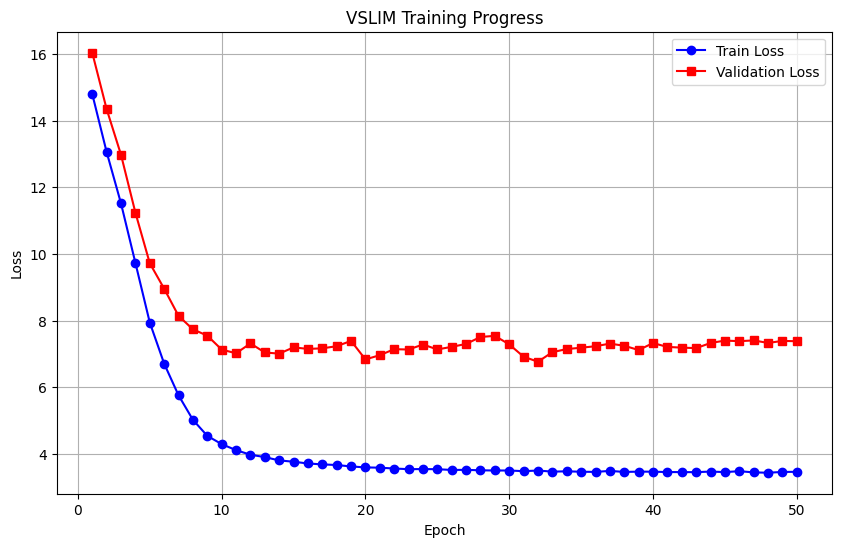

Training completed in 50 epochs
Best validation loss: inf


In [33]:
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VSLIM Training Progress')
plt.legend()
plt.grid(True)
plt.show()

print(f"Training completed in {len(train_losses)} epochs")
print(f"Best validation loss: {best_val_loss:.4f}")


In [34]:
# ====================
# 9) EVALUATION MODULE
# ====================

from seqeval.metrics import precision_score, recall_score, f1_score as seq_f1
from seqeval.metrics.sequence_labeling import get_entities

# ============= HELPER FUNCTIONS =============

def getEntities(elems):
    """
    Compress the entities
    For example: ['O', 'Good', 'Good', 'O', 'O']
                 will be compressed as [('O', 0, 1), ('Good', 1, 3), ('O', 3, 5)]
    """
    if isinstance(elems[0], list):
        elems = [item for sub in elems for item in sub + ['O']]

    current_char = elems[0]
    elem_len = len(elems)
    current_idx = 0
    ptr = current_idx + 1
    entities = []

    while ptr < elem_len:
        if ptr == elem_len - 1:
            if elems[ptr] == current_char:
                entities.append((current_char, current_idx, ptr + 1))
            else:
                entities.append((current_char, current_idx, ptr))
                entities.append((elems[ptr], ptr, ptr+1))
            break

        if elems[ptr] != current_char:
            entities.append((current_char, current_idx, ptr))
            current_idx = ptr
            current_char = elems[ptr]

        ptr += 1

    return entities

In [35]:
# ============= METRICS FUNCTIONS =============
def get_slot_metrics(preds, labels):
    """utils.py line 125-131"""
    assert len(preds) == len(labels)
    return {
        "slot_precision": precision_score(labels, preds),
        "slot_recall": recall_score(labels, preds),
        "slot_f1": seq_f1(labels, preds)
    }

def get_multi_intent_acc(intent_preds, intent_labels):
    """utils.py line 141-155"""
    intent_preds = intent_preds.tolist() if torch.is_tensor(intent_preds) else intent_preds.tolist()
    intent_labels = intent_labels.tolist() if torch.is_tensor(intent_labels) else intent_labels.tolist()
    records = []
    for ip, il in zip(intent_preds, intent_labels):
        one_sent = True
        for ipn, iln in zip(ip, il):
            if ipn != iln:
                one_sent = False
                break
        records.append(int(one_sent))

    return {
        "intent_acc": np.mean(records)
    }

def get_intent_token_metrics(intent_token_preds, intent_tokens):
    """utils.py line 220-245"""
    pred_tokens = set([item for item in getEntities(intent_token_preds) if item[0] != 'O'])
    true_tokens = set([item for item in getEntities(intent_tokens) if item[0] != 'O'])

    nb_correct = len(pred_tokens & true_tokens)
    nb_pred = len(pred_tokens)
    nb_true = len(true_tokens)

    pre = nb_correct / nb_pred if nb_pred > 0 else 0
    recall = nb_correct / nb_true if nb_true > 0 else 0
    score = 2 * pre * recall / (pre + recall) if pre + recall > 0 else 0

    return {
        'intent_token_precision': pre,
        'intent_token_recall': recall,
        'intent_token_f1': score,
    }

def get_tag_intent_metrics_fixed(tag_intent_preds, tag_intent_ids):
    """
    So sánh tag-intent CHỈ Ở VỊ TRÍ NON-PAD trong ground truth
    """
    total_cnt = 0
    correct_cnt = 0

    for pred_list, gt_list in zip(tag_intent_preds, tag_intent_ids):
        for pred, gt in zip(pred_list, gt_list):
            # CHỈ tính những vị trí có ground truth label (không phải PAD)
            if gt != "PAD":
                if pred == gt:
                    correct_cnt += 1
                total_cnt += 1

    return {
        'tag_intent_acc': correct_cnt / total_cnt if total_cnt > 0 else 0
    }

def get_semantic_basic_acc(intent_preds, intent_labels, slot_preds, slot_labels):
    """
    Semantic Basic Accuracy - CHỈ so sánh intent + slot
    (Không tính token-intent và tag-intent)
    """
    intent_preds = intent_preds.tolist() if torch.is_tensor(intent_preds) else intent_preds.tolist()
    intent_labels = intent_labels.tolist() if torch.is_tensor(intent_labels) else intent_labels.tolist()

    correct = 0
    total = len(intent_labels)

    for intent_pred, intent_label, slot_pred, slot_label in zip(
        intent_preds, intent_labels, slot_preds, slot_labels
    ):
        # Intent match (multi-hot comparison)
        intent_match = all(ip == il for ip, il in zip(intent_pred, intent_label))

        # Slot match (sequence comparison)
        slot_match = (slot_pred == slot_label)

        if intent_match and slot_match:
            correct += 1

    return {
        "semantic_basic_acc": correct / total if total > 0 else 0
    }

def get_sentence_frame_acc_multi_intent_fixed(intent_preds,
                                        intent_labels,
                                        slot_preds,
                                        slot_labels,
                                        intent_token_preds=None,
                                        intent_tokens=None,
                                        tag_intent_preds=None,
                                        tag_intent_labels=None):
    """
    FIX: CHỈ so sánh tag-intent ở vị trí NON-PAD
    """
    intent_token_existence = (intent_token_preds is not None and intent_tokens is not None)
    tag_intent_existence = (tag_intent_preds is not None and tag_intent_labels is not None)

    # Intent comparison
    intent_result = []
    intent_preds = intent_preds.tolist() if torch.is_tensor(intent_preds) else intent_preds.tolist()
    intent_labels = intent_labels.tolist() if torch.is_tensor(intent_labels) else intent_labels.tolist()

    for ip, il in zip(intent_preds, intent_labels):
        one_sent = True
        for ipn, iln in zip(ip, il):
            if ipn != iln:
                one_sent = False
                break
        intent_result.append(int(one_sent))
    intent_result = np.array(intent_result)

    # Slot comparison
    slot_result = []
    for preds, labels in zip(slot_preds, slot_labels):
        assert len(preds) == len(labels)
        one_sent_result = True
        for p, l in zip(preds, labels):
            if p != l:
                one_sent_result = False
                break
        slot_result.append(one_sent_result)

    slot_result = np.array(slot_result)

    # Intent token comparison
    if intent_token_existence:
        intent_token_result = []
        for preds, labels in zip(intent_token_preds, intent_tokens):
            assert len(preds) == len(labels)
            one_sent_result = True
            for p, l in zip(preds, labels):
                if p != l:
                    one_sent_result = False
                    break
            intent_token_result.append(one_sent_result)

        intent_token_result = np.array(intent_token_result)

    # Tag-intent comparison - FIX: CHỈ so sánh NON-PAD
    if tag_intent_existence:
        tag_intent_result = []
        for preds, labels in zip(tag_intent_preds, tag_intent_labels):
            one_sent_result = True
            for p, l in zip(preds, labels):
                # CHỈ so sánh khi ground truth không phải PAD
                if l != "PAD":
                    if p != l:
                        one_sent_result = False
                        break
            tag_intent_result.append(one_sent_result)

        tag_intent_result = np.array(tag_intent_result)

    # Combine all results
    if tag_intent_existence and intent_token_existence:
        sementic_acc = np.multiply(np.multiply(np.multiply(intent_result, slot_result), intent_token_result), tag_intent_result).mean()
    elif tag_intent_existence:
        sementic_acc = np.multiply(np.multiply(intent_result, slot_result), tag_intent_result).mean()
    elif intent_token_existence:
        sementic_acc = np.multiply(np.multiply(intent_result, slot_result), intent_token_result).mean()
    else:
        sementic_acc = np.multiply(intent_result, slot_result).mean()

    intent_slot_acc = np.multiply(intent_result, slot_result).mean()
    return {
        "sementic_frame_acc": sementic_acc,
        "intent_slot_acc": intent_slot_acc,
    }

def compute_metrics_multi_intent_fixed(intent_preds,
                                 intent_labels,
                                 slot_preds,
                                 slot_labels,
                                 intent_token_preds=None,
                                 intent_tokens=None,
                                 tag_intent_preds=None,
                                 tag_intent_ids=None):
    """FIX: Dùng hàm fixed"""
    intent_seq_existence = (intent_token_preds is not None and intent_tokens is not None)
    tag_intent_existence = (tag_intent_preds is not None and tag_intent_ids is not None)

    results = {}
    intent_result = get_multi_intent_acc(intent_preds, intent_labels)
    slot_result = get_slot_metrics(slot_preds, slot_labels)

    if intent_seq_existence:
        intent_token_result = get_intent_token_metrics(intent_token_preds, intent_tokens)

    if tag_intent_existence:
        tag_intent_result = get_tag_intent_metrics_fixed(tag_intent_preds, tag_intent_ids)  # FIX

    sementic_result = get_sentence_frame_acc_multi_intent_fixed(  # FIX
        intent_preds,
        intent_labels,
        slot_preds,
        slot_labels,
        intent_token_preds,
        intent_tokens,
        tag_intent_preds,
        tag_intent_ids)

    results.update(intent_result)
    results.update(slot_result)
    if intent_seq_existence:
        results.update(intent_token_result)
    if tag_intent_existence:
        results.update(tag_intent_result)
    results.update(sementic_result)

    return results

In [36]:
# ================================
# 10) VSLIM INFERENCE
# ================================

def align_tokens_for_inference(tokens: List[str], tokenizer, max_len=MAX_LEN):
    """Align pre-tokenized tokens to subwords for inference"""
    subword_tokens = []
    word_to_subword_map = []  # Maps word index to first subword index

    for token in tokens:
        word_to_subword_map.append(len(subword_tokens))
        pieces = tokenizer.tokenize(token) or [tokenizer.unk_token]
        subword_tokens.extend(pieces)

    # Convert to input IDs with special tokens
    input_ids = tokenizer.convert_tokens_to_ids(subword_tokens)
    input_ids = tokenizer.build_inputs_with_special_tokens(input_ids)

    # Adjust mapping for special tokens (e.g., <s> at beginning)
    word_to_subword_map = [idx + 1 for idx in word_to_subword_map]  # +1 for <s> token

    attention_mask = [1] * len(input_ids)
    token_type_ids = [0] * len(input_ids)

    # Truncate if necessary
    if len(input_ids) > max_len:
        input_ids = input_ids[:max_len]
        attention_mask = attention_mask[:max_len]
        token_type_ids = token_type_ids[:max_len]
        # Filter out word mappings that point beyond max_len
        word_to_subword_map = [idx for idx in word_to_subword_map if idx < max_len]

    # Pad to max_len
    pad_len = max_len - len(input_ids)
    if pad_len > 0:
        pad_id = tokenizer.pad_token_id
        input_ids.extend([pad_id] * pad_len)
        attention_mask.extend([0] * pad_len)
        token_type_ids.extend([0] * pad_len)

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(DEVICE),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0).to(DEVICE),
        torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0).to(DEVICE),
        word_to_subword_map
    )

def predict_full_slim(tokens: List[str], threshold: float = UTT_THRESHOLD) -> Dict[str, List[str]]:
    """
    Full SLIM inference with all paper features

    Args:
        tokens: Pre-tokenized input tokens
        threshold: Threshold for utterance intent classification

    Returns:
        Dictionary with utterance_intents, slot_tags, token_intents
    """
    model.eval()

    with torch.no_grad():
        # Prepare input
        input_ids, attention_mask, token_type_ids, word_positions = align_tokens_for_inference(tokens, tokenizer)

        # Create dummy B/BI masks for inference (all zeros since we don't have ground truth)
        batch_size, seq_len = input_ids.shape
        B_tag_mask = torch.zeros(batch_size, NUM_MASK, seq_len, dtype=torch.long, device=DEVICE)
        BI_tag_mask = torch.zeros(batch_size, NUM_MASK, seq_len, dtype=torch.float, device=DEVICE)
        tag_intent_label = torch.full((batch_size, NUM_MASK), IGNORE_INDEX, dtype=torch.long, device=DEVICE)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            intent_label_ids=None,  # No ground truth for inference
            slot_labels_ids=None,
            intent_token_ids=None,
            B_tag_mask=B_tag_mask,
            BI_tag_mask=BI_tag_mask,
            tag_intent_label=tag_intent_label
        )

        # Extract logits
        slot_logits = outputs["slot_logits"][0]      # [seq_len, num_slots]
        tokint_logits = outputs["intent_token_logits"][0] if outputs["intent_token_logits"] is not None else None  # [seq_len, num_tokints]
        uttint_logits = outputs["intent_logits"][0]  # [num_intents]

        # === UTTERANCE INTENT PREDICTION ===
        uttint_probs = uttint_logits.cpu().numpy()  # Already sigmoid from model
        predicted_intents = []

        # Apply threshold
        for i, prob in enumerate(uttint_probs):
            if prob >= threshold:
                predicted_intents.append(INTENT_LABELS[i])

        # Fallback: if no intent above threshold, take the highest
        if not predicted_intents:
            best_idx = np.argmax(uttint_probs)
            predicted_intents = [INTENT_LABELS[best_idx]]

        # === TOKEN-LEVEL PREDICTIONS ===
        # Get predictions for each original word (first subword only)
        slot_predictions = []
        tokint_predictions = []

        for word_idx, subword_pos in enumerate(word_positions):
            if subword_pos >= slot_logits.size(0):
                # Beyond sequence length, pad with "O"
                slot_predictions.append("O")
                tokint_predictions.append("O")
                continue

            # Slot prediction
            slot_id = torch.argmax(slot_logits[subword_pos]).item()
            slot_tag = ID2SLOT[slot_id]
            slot_predictions.append(slot_tag)

            # Token-intent prediction
            if tokint_logits is not None:
                if slot_tag == "O":
                    tokint_predictions.append("O")
                else:
                    tokint_id = torch.argmax(tokint_logits[subword_pos]).item()
                    tokint_tag = ID2TOKINT[tokint_id]
                    tokint_predictions.append(tokint_tag)
            else:
                tokint_predictions.append("O")

            # # ✅ Token-intent prediction (CORRECTED - độc lập với slots)
            # if tokint_logits is not None:
            #     tokint_id = torch.argmax(tokint_logits[subword_pos]).item()
            #     tokint_tag = ID2TOKINT[tokint_id]
            #     tokint_predictions.append(tokint_tag)
            # else:
            #     # Nếu model không output token-intent logits
            #     tokint_predictions.append("O")

        # Ensure output length matches input length
        num_tokens = len(tokens)
        if len(slot_predictions) < num_tokens:
            slot_predictions.extend(["O"] * (num_tokens - len(slot_predictions)))
            tokint_predictions.extend(["O"] * (num_tokens - len(tokint_predictions)))
        elif len(slot_predictions) > num_tokens:
            slot_predictions = slot_predictions[:num_tokens]
            tokint_predictions = tokint_predictions[:num_tokens]

    return {
        "utterance_intents": predicted_intents,
        "slot_tags": slot_predictions,
        "token_intents": tokint_predictions
    }

def show_prediction(tokens: List[str], prediction: Dict[str, List[str]]):
    """Display prediction in a readable format"""
    print("Tokens:       ", " ".join(tokens))
    print("Utter intents:", prediction["utterance_intents"])
    print("Slots:        ", " ".join(prediction["slot_tags"]))
    print("Tok-intents:  ", " ".join(prediction["token_intents"]))
    print("-" * 60)

print("VSLIM inference ready!")

VSLIM inference ready!


In [37]:
# ============= 2-PASS EVALUATION =============

def generate_predicted_masks_from_slots(slot_preds_list, max_seq_len=MAX_LEN):
    """
    Generate B AND BI masks from predicted slots
    """
    B_tag_mask_pred = []
    BI_tag_mask_pred = []

    for i in range(len(slot_preds_list)):
        entities = get_entities(slot_preds_list[i])
        entities = [tag for tag in entities if slot_preds_list[i][tag[1]].startswith('B')]

        if len(entities) > NUM_MASK:
            entities = entities[:NUM_MASK]

        # Initialize both masks
        B_entity_masks = []
        BI_entity_masks = []

        for entity_idx, entity in enumerate(entities):
            # B mask: only mark beginning
            B_mask = [0 for _ in range(max_seq_len)]
            start_idx = entity[1]
            B_mask[start_idx] = 1
            B_entity_masks.append(B_mask)

            # BI mask: weighted span
            BI_mask = [0.0 for _ in range(max_seq_len)]
            end_idx = entity[2] + 1
            weight = 1.0 / (end_idx - start_idx)
            for pos in range(start_idx, end_idx):
                if pos < len(slot_preds_list[i]):
                    BI_mask[pos] = weight
            BI_entity_masks.append(BI_mask)

        # Pad to NUM_MASK
        for extra_idx in range(NUM_MASK - len(B_entity_masks)):
            B_entity_masks.append([0 for _ in range(max_seq_len)])
            BI_entity_masks.append([0.0 for _ in range(max_seq_len)])

        B_tag_mask_pred.append(B_entity_masks)
        BI_tag_mask_pred.append(BI_entity_masks)

    return torch.LongTensor(B_tag_mask_pred), torch.FloatTensor(BI_tag_mask_pred)

def align_masks_to_subwords(masks, word_to_subword_map, max_len):
    """Align word-level masks to subword-level masks"""
    num_masks = len(masks)
    aligned_masks = torch.zeros(num_masks, max_len, dtype=torch.float)

    for mask_idx in range(num_masks):
        for word_idx, subword_idx in enumerate(word_to_subword_map):
            if word_idx < len(masks[mask_idx]) and subword_idx < max_len:
                aligned_masks[mask_idx, subword_idx] = masks[mask_idx][word_idx]

    return aligned_masks

def evaluate_2pass(mode='test'):
    if mode == 'test':
        dataset_sentences = load_data_with_masks(TEST_DIR)[0]
        dataset_slots = load_data_with_masks(TEST_DIR)[1]
        dataset_tokints = load_data_with_masks(TEST_DIR)[2]
        dataset_intents = load_data_with_masks(TEST_DIR)[3]
        dataset_tag_intents = load_data_with_masks(TEST_DIR)[6]
    elif mode == 'dev':
        dataset_sentences = dev_sentences
        dataset_slots = dev_slot_tags
        dataset_tokints = dev_token_intent_tags
        dataset_intents = dev_utterance_intents
        dataset_tag_intents = dev_tag_intent_labels
    else:
        raise ValueError("Mode must be 'test' or 'dev'")

    print(f"***** Running evaluation on {mode} dataset *****")
    print(f"  Num examples = {len(dataset_sentences)}")

    # ========== PASS 1: Predict intents and slots ==========
    intent_preds = []
    slot_preds = []
    intent_token_preds = []
    out_intent_label_ids = []
    out_slot_labels_ids = []
    out_intent_token_ids = []

    model.eval()

    for tokens, slot_tags, tokint_tags, utt_intents in zip(
        dataset_sentences, dataset_slots, dataset_tokints, dataset_intents):

        with torch.no_grad():
            result = predict_full_slim(tokens)

            # Intent predictions (multi-hot)
            intent_multihot = [0] * len(INTENT_LABELS)
            for intent in result["utterance_intents"]:
                if intent in INTENT2ID:
                    intent_multihot[INTENT2ID[intent]] = 1
            intent_preds.append(intent_multihot)

            # Gold intent (multi-hot)
            gold_multihot = [0] * len(INTENT_LABELS)
            for intent in utt_intents:
                if intent in INTENT2ID:
                    gold_multihot[INTENT2ID[intent]] = 1
            out_intent_label_ids.append(gold_multihot)

            # Slot predictions
            slot_preds.append(result["slot_tags"])
            out_slot_labels_ids.append(slot_tags)

            # Token-intent predictions
            intent_token_preds.append(result["token_intents"])
            out_intent_token_ids.append(tokint_tags)

    # Convert to proper format
    intent_preds = torch.as_tensor(intent_preds, dtype=torch.int32)
    out_intent_label_ids = np.array(out_intent_label_ids)

    # ========== Generate predicted masks ==========
    slot_label_map = {i: label for i, label in enumerate(SLOT_LABELS)}
    slot_preds_list = slot_preds  # Already in list format
    out_slot_label_list = out_slot_labels_ids  # Already in list format

    # Generate masks from predicted slots
    B_tag_mask_pred_tensor, BI_tag_mask_pred_tensor = generate_predicted_masks_from_slots(slot_preds_list, max_seq_len=MAX_LEN)

    # ========== PASS 2: Predict tag-intents with predicted masks ==========
    tag_intent_preds = []
    out_tag_intent_ids = []

    model.eval()

    for idx, tokens in enumerate(dataset_sentences):
        with torch.no_grad():
            # Prepare input
            input_ids, attention_mask, token_type_ids, word_positions = \
                align_tokens_for_inference(tokens, tokenizer)

            batch_size, seq_len = input_ids.shape

            # Get predicted masks for this sample
            B_mask = B_tag_mask_pred_tensor[idx].numpy().tolist()  # ← THÊM DÒNG NÀY
            BI_mask = BI_tag_mask_pred_tensor[idx].numpy().tolist()

            # Align to subwords
            B_mask_tensor = align_masks_to_subwords(B_mask, word_positions, seq_len)  # ← THÊM DÒNG NÀY
            B_mask_tensor = B_mask_tensor.unsqueeze(0).to(DEVICE).long()  # ← THÊM DÒNG NÀY

            BI_mask_tensor = align_masks_to_subwords(BI_mask, word_positions, seq_len)
            BI_mask_tensor = BI_mask_tensor.unsqueeze(0).to(DEVICE)

            # KHÔNG CÒN: B_mask_tensor = None  ← XÓA DÒNG NÀY
            tag_intent_label = torch.full((1, NUM_MASK), IGNORE_INDEX, dtype=torch.long, device=DEVICE)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                intent_label_ids=None,
                slot_labels_ids=None,
                intent_token_ids=None,
                B_tag_mask=B_mask_tensor,  # ← BÂY GIỜ KHÔNG PHẢI None
                BI_tag_mask=BI_mask_tensor,
                tag_intent_label=tag_intent_label
            )

            # Extract tag-intent predictions
            if outputs["tag_intent_logits"] is not None:
                tag_intent_logits = outputs["tag_intent_logits"].view(NUM_MASK, -1)
                tag_intent_pred = torch.argmax(tag_intent_logits, dim=-1).cpu().numpy()

                # Convert to labels
                pred_labels = []
                for pred_id in tag_intent_pred:
                    pred_label = ID2TAGINT.get(pred_id, "PAD")
                    pred_labels.append(pred_label)

                tag_intent_preds.append(pred_labels)
            else:
                tag_intent_preds.append(["PAD"] * NUM_MASK)

            # Gold tag intents
            gold_labels = []
            for label_id in dataset_tag_intents[idx]:
                gold_label = ID2TAGINT.get(label_id, "PAD")
                gold_labels.append(gold_label)
            out_tag_intent_ids.append(gold_labels)

    # ========== Compute metrics ==========
    intent_token_map = {i: label for i, label in enumerate(INTENT_LABELS)}

    # Format predictions to match repo format
    out_intent_token_list = out_intent_token_ids
    intent_token_preds_list = intent_token_preds
    out_tag_intent_list = out_tag_intent_ids
    tag_intent_preds_list = tag_intent_preds

    # Compute all metrics
    total_result = compute_metrics_multi_intent_fixed(
        intent_preds,
        out_intent_label_ids,
        slot_preds_list,
        out_slot_label_list,
        intent_token_preds_list,
        out_intent_token_list,
        tag_intent_preds_list,
        out_tag_intent_list
    )

    # ✅ THÊM: Compute semantic basic accuracy
    semantic_basic_result = get_semantic_basic_acc(
        intent_preds,
        out_intent_label_ids,
        slot_preds_list,
        out_slot_label_list
    )

    # ✅ THÊM: Merge results
    results = total_result
    results.update(semantic_basic_result)  # Thêm semantic_basic_acc vào results

    # ✅ SỬA: Uncomment và tạo predictions dictionary
    predictions = {
        "intents": intent_preds.tolist(),  # Convert tensor to list
        "slots": slot_preds_list,
        "tokints": intent_token_preds_list,
        "tag_intents": tag_intent_preds_list
    }

    # ✅ SỬA: Thêm predictions vào results
    results["predictions"] = predictions


    print("***** Eval results *****")
    for key in sorted(results.keys()):
        if isinstance(results[key], (int, float)):  # Only format numbers
            print(f"  {mode}_{key} = {results[key]:.4f}")
        else:
            print(f"  {mode}_{key} = {type(results[key])}")  # Show type for non-numeric values

    return results

print("✅ 2-Pass Evaluation Module Ready (Y CHANG REPO GỐC)!")

✅ 2-Pass Evaluation Module Ready (Y CHANG REPO GỐC)!


In [38]:
# ================================
# 11) INFERENCE DEMO ON SAMPLE SENTENCES
# ================================

# Demo examples (Vietnamese pre-tokenized sentences)
demo_examples = [
    ["Tôi", "vừa", "chi", "2", "triệu", "cho", "ăn_uống"],
    ["Thống_kê", "chi_tiêu", "tháng", "này"],
    ["Tìm", "giao_dịch", "ăn_trưa", "hôm_qua"],
    ["Sửa", "tiền_điện", "tháng_7", "thành", "900", "nghìn"],
    ["Xoá", "giao_dịch", "tại", "Hà_Nội"],
    ["Tôi", "vừa", "giao_dịch", "2", "triệu", ",", "xoá", "giao_dịch", "3", "triệu", "hôm_qua"],
    ["Xoá", "giao_dịch", "tại", "Hà_Nội", ",", "thêm", "3", "triệu", "tiền", "cơm"]
]

print("🚀 FULL SLIM INFERENCE DEMO")
print("="*80)
print(f"Model: {MODEL_NAME}")
print(f"Threshold: {UTT_THRESHOLD}")
print(f"Schema: {len(INTENT_LABELS)} intents, {len(SLOT_LABELS)} slots, {len(TOKEN_INTENT_LABELS)} token-intents")
print(f"Features: CRF={model.use_crf}, Tag-Intent={model.num_mask} masks, Intent-Attn={model.intent_attn}")
print("="*80)

for i, tokens in enumerate(demo_examples, 1):
    print(f"\nExample {i}:")
    prediction = predict_full_slim(tokens, threshold=UTT_THRESHOLD)
    show_prediction(tokens, prediction)

print("Demo completed! ✅")


🚀 FULL SLIM INFERENCE DEMO
Model: vinai/phobert-base-v2
Threshold: 0.5
Schema: 5 intents, 17 slots, 6 token-intents
Features: CRF=False, Tag-Intent=4 masks, Intent-Attn=True

Example 1:
Tokens:        Tôi vừa chi 2 triệu cho ăn_uống
Utter intents: ['add_expense']
Slots:         O O O B-target_price I-target_price O B-target_description
Tok-intents:   O O O add_expense add_expense O add_expense
------------------------------------------------------------

Example 2:
Tokens:        Thống_kê chi_tiêu tháng này
Utter intents: ['stat_expense']
Slots:         O B-condition_description B-condition_date I-condition_date
Tok-intents:   O stat_expense stat_expense stat_expense
------------------------------------------------------------

Example 3:
Tokens:        Tìm giao_dịch ăn_trưa hôm_qua
Utter intents: ['search_expense']
Slots:         O O B-condition_description B-condition_date
Tok-intents:   O O search_expense search_expense
------------------------------------------------------------

E

In [39]:
# ================================
# 12) FULL EVALUATION ON TEST SET
# ================================

# Run complete evaluation
print("RUNNING FULL EVALUATION ON TEST SET")
print("="*80)

evaluation_results = evaluate_2pass(mode='test')

test_data = load_data_with_masks(TEST_DIR, is_test=True)

print("\nSUMMARY:")
print(f"  Best metric - Intent Acc:       {evaluation_results['intent_acc']:.4f}")
print(f"  Best metric - Slot F1:          {evaluation_results['slot_f1']:.4f}")
print(f"  Best metric - Joint Acc Basic:  {evaluation_results['semantic_basic_acc']:.4f}")
print(f"  Best metric - Joint Acc Exact:  {evaluation_results['sementic_frame_acc']:.4f}")

RUNNING FULL EVALUATION ON TEST SET
Loaded 115 examples from /content/drive/MyDrive/dataset/vped/test
Sample: tokens=['Tôi', 'vừa', 'chi', '200', 'nghìn'], intents=['add_expense'], slots=['O', 'O', 'O', 'B-target_price', 'I-target_price']
Loaded 115 examples from /content/drive/MyDrive/dataset/vped/test
Sample: tokens=['Tôi', 'vừa', 'chi', '200', 'nghìn'], intents=['add_expense'], slots=['O', 'O', 'O', 'B-target_price', 'I-target_price']
Loaded 115 examples from /content/drive/MyDrive/dataset/vped/test
Sample: tokens=['Tôi', 'vừa', 'chi', '200', 'nghìn'], intents=['add_expense'], slots=['O', 'O', 'O', 'B-target_price', 'I-target_price']
Loaded 115 examples from /content/drive/MyDrive/dataset/vped/test
Sample: tokens=['Tôi', 'vừa', 'chi', '200', 'nghìn'], intents=['add_expense'], slots=['O', 'O', 'O', 'B-target_price', 'I-target_price']
Loaded 115 examples from /content/drive/MyDrive/dataset/vped/test
Sample: tokens=['Tôi', 'vừa', 'chi', '200', 'nghìn'], intents=['add_expense'], slots=[